In [48]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from pathlib import Path
import numpy as np
from utils.models import Classifier
import torch.nn as nn
from utils.loader2 import Loader

In [58]:
finger_type=0
data_dir ='../../aug6_rpg_data/'
sample_file = 1
#output_size = 6
model_path = '/home/tasbolat/tas_python_env/.guild/runs/7ae0d370cf124804acd29063b82c0028/weights-020.pt'
lr = 0.0001

In [59]:






# Dataset definition
class RawDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, modals=0):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile, dtype=str)
        

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = int(self.samples[index, 1])
        #desiredClass = torch.zeros((20, 1, 1, 1))
        #desiredClass[classLabel,...] = 1
        inputSpikes = torch.FloatTensor( np.load(self.path + inputIndex + '_vis.npy') )
        return inputSpikes, classLabel
        
    def __len__(self):
        return self.samples.shape[0]


# In[15]:


device = torch.device('cuda:0')



class FLAGS():
    def __init__(self):
        self.batch_size = 4
        self.pin_memory =True
        self.num_workers = 1
        self.device = device
flags = FLAGS()






In [60]:
    
trainingSet = RawDataset(datasetPath = data_dir + 'vis_rpg_data/', 
                        sampleFile = data_dir + "/train_80_20_" + str(sample_file) + ".txt")
train_loader = Loader(trainingSet, flags, device=device)    

testingSet = RawDataset(datasetPath = data_dir + 'vis_rpg_data/', 
                        sampleFile  = data_dir + "/test_80_20_" + str(sample_file) + ".txt")
test_loader = Loader(testingSet, flags, device=device)

# model parameters



model = Classifier(num_classes=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)



criterion = torch.nn.CrossEntropyLoss()


100%|██████████| 1000/1000 [00:14<00:00, 69.52it/s]


In [61]:
model.load_state_dict(torch.load(model_path))
model.eval()

Classifier(
  (quantization_layer): QuantizationLayer(
    (value_layer): ValueLayer(
      (mlp): ModuleList(
        (0): Linear(in_features=1, out_features=30, bias=True)
        (1): Linear(in_features=30, out_features=30, bias=True)
        (2): Linear(in_features=30, out_features=1, bias=True)
      )
      (activation): LeakyReLU(negative_slope=0.1)
    )
  )
  (classifier): ResNet(
    (conv1): Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64

In [62]:
correct = 0
sum_loss = 0
model.eval()
with torch.no_grad():
    for events1,  labels in test_loader:       
        out, vox1 = model.forward(events1)
        loss = criterion(out, labels)
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()        
validation_loss = sum_loss / len(testingSet)
validation_accuracy = correct / len(testingSet)

In [63]:
len(testingSet)

60

In [64]:
correct

44

In [65]:
correct/60

0.7333333333333333

In [66]:
labels.cpu().numpy()

array([ 4, 10,  0,  4])

In [67]:
len(testingSet)

60

In [68]:
count = 0
total_testing_true=None
testing_true = torch.zeros([len(testingSet),2])
ll = []
for events1, labels in test_loader:
    label = labels.cpu()
    testing_true[count:count+label.shape[0],0] = label
    with torch.no_grad():
        # Forward pass of the network.
        out, vox1 = model.forward(events1)
        _, predicted_label = torch.max(out.data, 1)
        testing_true[count:count+label.shape[0],1] = predicted_label
    count += label.shape[0]
    ll.append(label)
if total_testing_true is None:
    total_testing_true = testing_true
else:
    total_testing_true = torch.cat([total_testing_true, testing_true])

In [69]:
from sklearn.metrics import confusion_matrix

In [70]:
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy()).T

In [71]:
import seaborn as sn

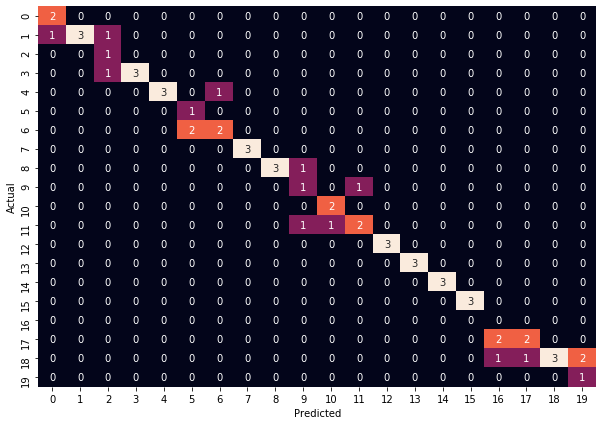

In [72]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('imgs_july30/rpg_vision_'+str(sample_file)+'.png')
plt.show()

In [73]:
list_of_objects3 = [
    "Pepsi 0",
    "Pepsi 25",
    "Pepsi 50",
    "Pepsi 75",
    "Pepsi 100",
    "Tuna 0",
    "Tuna 25",
    "Tuna 50",
    "Tuna 75",
    "Tuna 100",
    "Soy 0",
    "Soy 25",
    "Soy 50",
    "Soy 75",
    "Soy 100",
    "Coffee 0",
    "Coffee 25",
    "Coffee 50",
    "Coffee 75",
    "Coffee 100",
]

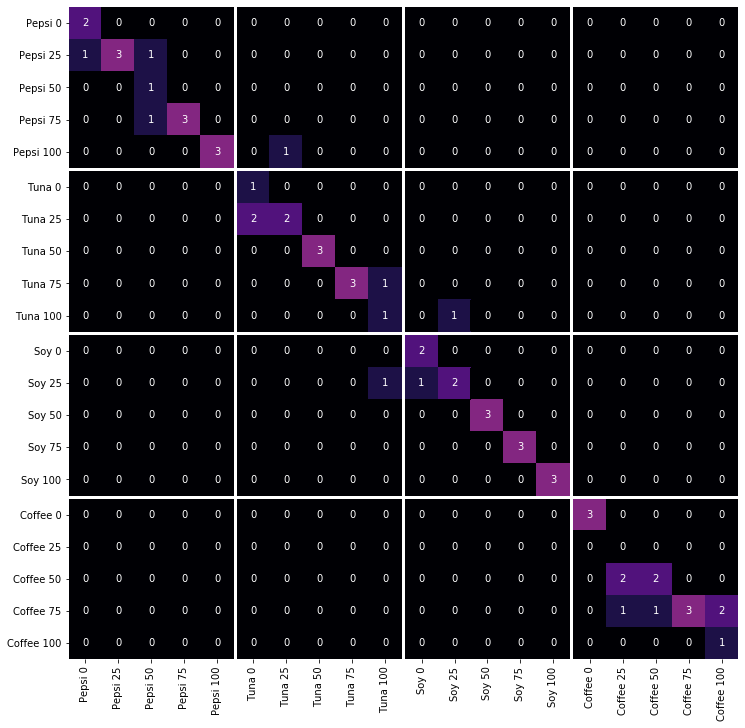

In [77]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(12,12))

for i in range(0,20,5):
    for j in range(0,20,5):
        if i == 15:
            xticklabels = list_of_objects3[j:j+5]
        else:
            xticklabels = False
        if j == 0:
            yticklabels = list_of_objects3[i:i+5]
        else:
            yticklabels = False
            
        sn.heatmap(cm[i:i+5,j:j+5], annot=True, cbar=False,
                   ax=ax[int(i/5)][int(j/5)], vmin=0, vmax=8,
                  xticklabels=xticklabels, yticklabels=yticklabels, cmap='magma')
plt.subplots_adjust(hspace=0.02, wspace=0.02)
plt.savefig('est_confusion_matrix.png')
plt.show()